## Topic Modeling for Libraray Dialouges

In [1]:
#some library imports
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import pandas as pd
import os

In [2]:
# load the file
df = pd.read_csv("./data/all_chats_0330_startlineFalse.csv")
logs = df["chat"]

### The number of dialouge sessions up to date

In [3]:
len(logs)

741

### Data Class with user and lib utters and add_from_log function

In [4]:
class ChatData():
    
    def __init__(self, user_utters = None, lib_utters = None):
        
        if user_utters:
            self.user_utters = user_utters
            
        else:
            self.user_utters = []
            
        if lib_utters:
            self.lib_utters = lib_utters
            
        else:
            self.lib_utters = []
            
    def add_from_log(self, log, show_errors = False):
    # take a log and split the log into lines and add the utterences according to role    
        assert type(log) == str, "Wrong type of log, should be type of str"
        
        error_logs = []

        lines = log.split("\n")
        for line in lines:
            line_splitted = line.split(" ")
            if len(line_splitted) > 1:
                role, utter = line_splitted[0].strip(), " ".join(line_splitted[1:]).strip()
                if role == "<user>":
                    self.user_utters.append(utter)
                elif role =="<librarian>":
                    self.lib_utters.append(utter)
                else:
                    pass
            else:
                error_logs.append(line)
        if show_errors:
            print("Fllowing utterances are not added")
            print(error_logs)
            

In [5]:
data = ChatData()
for log in logs:
    data.add_from_log(log)
user_utters = data.user_utters
lib_utters = data.lib_utters
# filter all the invalid lines(with len == 0)
user_utters = [utter for utter in user_utters if len(utter)>0]
lib_utters = [utter for utter in lib_utters if len(utter)>0]

In [6]:
# data to feed the models
user_data = pd.DataFrame(user_utters)[0]
lib_data = pd.DataFrame(lib_utters)[0]

In [23]:
total_data = user_data+lib_data[0]

#### Exploratory Analysis

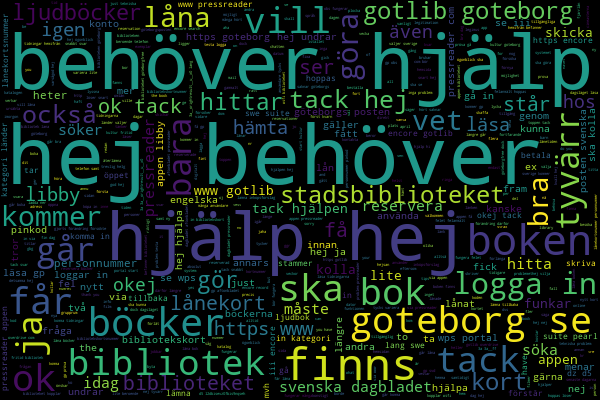

In [72]:
from wordcloud import WordCloud

stopwords = nltk.corpus.stopwords.words("swedish")

# Join the different processed titles together.
long_string1 = ','.join(list(user_utters))
long_string2 = ",".join(list(lib_utters))

# Create a WordCloud object
wordcloud = WordCloud(stopwords=stopwords,background_color="black", width=600,
                        height=400,max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string1+long_string2)

# Visualize the word cloud
wordcloud.to_image()

In [73]:
stopwords_extra = ["librarian","user","hej","in", "tack", "ok","bok", "behöver", "hjälp","hjälpen"]
stopwords = stopwords + stopwords_extra

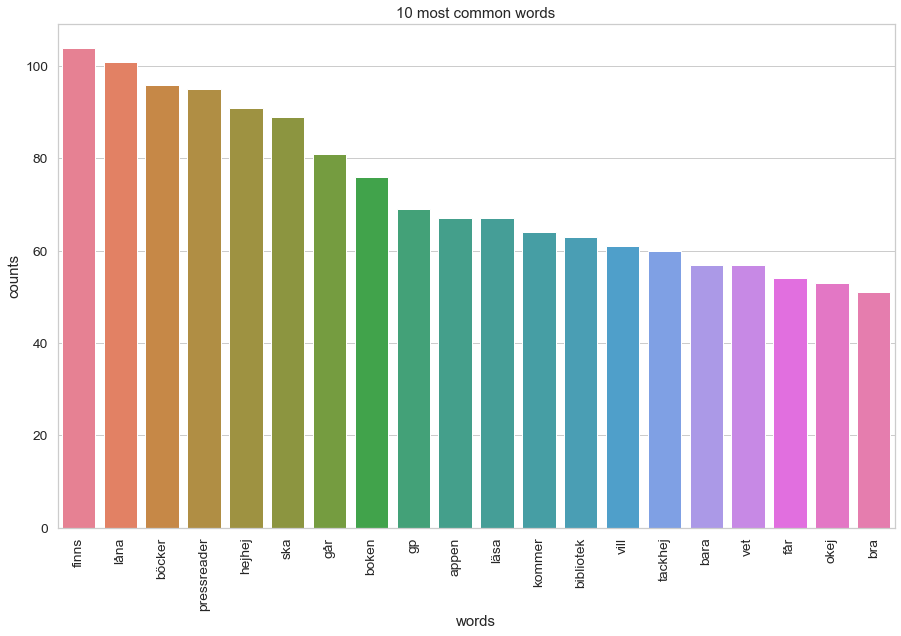

In [74]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the Swedish stop words
count_vectorizer = CountVectorizer(stop_words=stopwords)

# Fit and transform the processed utters
count_data = count_vectorizer.fit_transform(total_data)

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

# Initialise the tfidf vectorizer with the Swedish stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords)

# Fit and transform the processed utters
tfidf_data = tfidf_vectorizer.fit_transform(logs)

### LDA
#### Remark: Change the number of topics and number of words yielded for each topic below

In [69]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 15
number_words = 25

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics founds via LDA-TM:")
print_topics(lda, count_vectorizer, number_words)

Topics founds via LDA-TM:

Topic #0:
logga appen personnummer pinkod första alltså bara låna vill får biblioteket läsa glömt gången undrar går försöker även måste säger mvhhej va bibliotek vet kommer

Topic #1:
bra dag testhej gång fin pressreaderhej testar daghej bara göra genom fråga stadsbiblioteket går författare ja kommer inköp vill fortfarande behöva lånekort många låna boka

Topic #2:
tackhej okej finns it boken to do ljudböckerhej can gjort hittar the boka will you is appen innan book reserverat synd ibland hämta undrar angående

Topic #3:
finns svenska dagbladet böckerhej dator också låna hämta böcker hittar pressreader idag veta vilja infon posten går ska vet gotlib infohej kanske väl bibliotek spelet

Topic #4:
svar söker låna ja står snabbt finns böcker heter denhej andra appen boken undrar hemsidan the får hitta have bibliotekhej gå ljudböcker vet hittar göra

Topic #5:
vet hjälpenhej funkar se jaghej ska böcker bra bibliotek ner göra förstår ladda titta stadsbiblioteket h

### Some help and visulasation for topic modeling analysis
#### Remark: adjust the value of λ to better filter out not topic specific words

In [63]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [70]:
lda_tf = LDA(n_components=15,random_state=0)
lda_tf.fit(count_data)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=15, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [71]:
pyLDAvis.sklearn.prepare(lda_tf, count_data, count_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.196586 -0.057102       1        1  10.105987
12     0.002495  0.195711       2        1   8.516201
2     -0.122693  0.019998       3        1   7.364447
14     0.008018  0.035892       4        1   7.215002
5      0.017034  0.007566       5        1   6.873541
3     -0.021216  0.060318       6        1   6.789830
0     -0.056216  0.000682       7        1   6.716965
7      0.007097 -0.105693       8        1   6.655530
6      0.026992 -0.040119       9        1   6.506781
8      0.046010  0.002924      10        1   6.206458
9      0.133169 -0.040247      11        1   6.069687
13     0.039035  0.007820      12        1   5.948455
10     0.032772 -0.097833      13        1   5.279682
4      0.004761 -0.010733      14        1   4.892344
1      0.079329  0.020817      15        1   4.859090, topic_info=             Term       Freq      Total Category  logprob  loglift
1263       hejhej  68.000000  68.000000  Default  30.0000  30.0000
2995      tackhej  45.000000  45.000000  Default  29.0000  29.0000
2255         okej  40.000000  40.000000  Default  28.0000  28.0000
2432  pressreader  75.000000  75.000000  Default  27.0000  27.0000
1175           gp  55.000000  55.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
1032           få   2.922806  31.177646  Topic15  -5.1451   0.6572
1938         låna   3.247827  75.234308  Topic15  -5.0396  -0.1183
2982        söker   2.164584  21.594304  Topic15  -5.4454   0.7241
3037          the   2.164585  24.609931  Topic15  -5.4454   0.5934
3313          vet   2.239275  43.289688  Topic15  -5.4115   0.0626

[1028 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3         2  0.671434   01385
5         5  0.664720     021
5        12  0.332360     021
8         1  0.846746      03
10       15  0.464144     031
...     ...       ...     ...
3492      7  0.121115   öppet
3492      8  0.121115   öppet
3492     12  0.242230   öppet
3496      2  0.672983  öppnas
3496     10  0.336492  öppnas

[2078 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 13, 3, 15, 6, 4, 1, 8, 7, 9, 10, 14, 11, 5, 2])